In [1]:
from tensorflow.keras.callbacks import Callback
import pandas as pd
import random 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.pylab import mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU,Conv1D,Dense
from tcn import TCN,tcn_full_summary
from sklearn.metrics import mean_squared_error # 均方误差
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input,Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

### Keras设置随机种子

In [2]:
my_seed = 666
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)

In [3]:
female_train_audio_path = 'H:/data/audio_data/female_train_D_feature/female_train_D_audio.csv'
female_dev_audio_path = 'H:/dev_data/audio_data/female_dev_D_feature/female_dev_D_audio.csv'
female_dev_audio_path2 = 'H:/dev_data/audio_data/female_dev_ND_feature/female_dev_ND_audio.csv'
female_train_audio_path2 = 'H:/data/audio_data/female_train_ND_feature/female_train_ND_audio.csv'

male_train_audio_path = 'H:/data/audio_data/male_train_D_feature/male_train_D_audio.csv'
male_dev_audio_path = 'H:/dev_data/audio_data/male_dev_D_feature/male_dev_D_audio.csv'
male_dev_audio_path2 = 'H:/dev_data/audio_data/male_dev_ND_feature/male_dev_ND_audio.csv'
male_train_audio_path2 = 'H:/data/audio_data/male_train_ND_feature/male_train_ND_audio.csv'

df1 = pd.read_csv(female_train_audio_path,index_col=0)
df2 = pd.read_csv(female_dev_audio_path,index_col=0)
df3 = pd.read_csv(female_dev_audio_path2,index_col=0)
df4 = pd.read_csv(female_train_audio_path2,index_col=0)

df5 = pd.read_csv(male_train_audio_path,index_col=0)
df6 = pd.read_csv(male_dev_audio_path,index_col=0)
df7 = pd.read_csv(male_dev_audio_path2,index_col=0)
df8 = pd.read_csv(male_train_audio_path2,index_col=0)

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8],ignore_index=True)
df = df.sample(frac=1.0).reset_index(drop=True)

### 对数据进行归一化

In [4]:
len1 = int(df.shape[0]*0.9)
train=df[:len1]
test=df[len1:]

#不对y进行归一化
X_Train=train.iloc[:,:-1]
Y_train=train.iloc[:,-1:]
X_Test=test.iloc[:,:-1]
Y_test=test.iloc[:,-1:]

In [5]:
# 标准化
# scaler = StandardScaler().fit(X_Train)
# X_train = pd.DataFrame(scaler.transform(X_Train))
# X_test = pd.DataFrame(scaler.transform(X_Test))
# #归一化
df = df.iloc[:,:-1]
scaler = MinMaxScaler(feature_range=(-1,1)).fit(df)
X_train=pd.DataFrame(scaler.fit_transform(X_Train))
X_test=pd.DataFrame(scaler.transform(X_Test))

In [18]:
Y_test = Y_test.reset_index(drop=True)
Y_test.head(10)

,6373
0,0.0
1,10.0
2,3.0
3,3.0
4,16.0
5,9.0
6,12.0
7,11.0
8,18.0
9,7.0


In [7]:
audio_dev = pd.concat([X_test,Y_test],ignore_index=True,axis=1)
audio_dev.to_csv("audio_dev.csv")

### 转换为3维数据 [samples, timesteps, features]

In [8]:
x_train=X_train.values.reshape([X_train.shape[0],1,X_train.shape[1]]) 
x_test=X_test.values.reshape([X_test.shape[0],1,X_test.shape[1]])  
y_train=Y_train.values
y_test=Y_test.values

In [9]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((520, 1, 6373), (520, 1), (58, 1, 6373), (58, 1))

### 构造TCN模型

In [10]:
def rmse(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [11]:
batch_size=None
timesteps=x_train.shape[1]
input_dim=x_train.shape[2] #输入维数
tcn = Sequential()
input_layer =Input(batch_shape=(batch_size,timesteps,input_dim))
tcn.add(input_layer)
tcn.add(TCN(nb_filters=32, #在卷积层中使用的过滤器数。可以是列表。
        kernel_size=2, #在每个卷积层中使用的内核大小。
        nb_stacks=1,   #要使用的残差块的堆栈数。
        dilations=[2 ** i for i in range(4)], #扩张列表。示例为：[1、2、4、8、16、32、64]。
        #用于卷积层中的填充,值为'causal' 或'same'。
        #“causal”将产生因果（膨胀的）卷积，即output[t]不依赖于input[t+1：]。当对不能违反时间顺序的时序信号建模时有用。
        #“same”代表保留边界处的卷积结果，通常会导致输出shape与输入shape相同。
        padding='causal',
        use_skip_connections=True, #是否要添加从输入到每个残差块的跳过连接。
        dropout_rate=0.3, #在0到1之间浮动。要下降的输入单位的分数。
        return_sequences=False,#是返回输出序列中的最后一个输出还是完整序列。
        activation='relu', #残差块中使用的激活函数 o = Activation(x + F(x)).
        kernel_initializer='he_normal', #内核权重矩阵（Conv1D）的初始化程序。
        use_batch_norm=True, #是否在残差层中使用批处理规范化。
#         use_layer_norm=False, #是否在残差层中使用层归一化。
        name='tcn' #使用多个TCN时，要使用唯一的名称
        ))
tcn.add(tf.keras.layers.Dense(1))
tcn.compile('adam', loss=rmse, metrics=['mae'])
tcn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 32)                627456    
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 627,489
Trainable params: 626,977
Non-trainable params: 512
_________________________________________________________________


In [12]:
early_stopping = EarlyStopping(monitor='val_mae', patience=20, verbose=2)
checkpoint = ModelCheckpoint('audio_4.h5', monitor='val_mae', verbose=1,save_best_only=True,mode='min',period=2)
callbacks_list=[checkpoint,early_stopping]
history=tcn.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32,callbacks=[callbacks_list])

Epoch 1/100
17/17 [==============================] - 0s 24ms/step - loss: 10.8853 - mae: 9.1898 - val_loss: 19.3535 - val_mae: 18.5097
Epoch 2/100
10/17 [================>.............] - ETA: 0s - loss: 9.8453 - mae: 8.1527
Epoch 00002: val_mae improved from inf to 10.02468, saving model to audio_4.h5
17/17 [==============================] - 0s 11ms/step - loss: 9.9109 - mae: 8.2837 - val_loss: 11.4331 - val_mae: 10.0247
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 8.5685 - mae: 7.0600 - val_loss: 5.6803 - val_mae: 4.7206
Epoch 4/100
10/17 [================>.............] - ETA: 0s - loss: 7.7391 - mae: 6.3496
Epoch 00004: val_mae improved from 10.02468 to 6.32662, saving model to audio_4.h5
17/17 [==============================] - 0s 11ms/step - loss: 7.4700 - mae: 6.1774 - val_loss: 7.8020 - val_mae: 6.3266
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 6.3542 - mae: 5.1702 - val_loss: 8.1224 - val_mae: 6.9245
Epoch 6/100
10/17 [

Epoch 41/100
17/17 [==============================] - 0s 7ms/step - loss: 2.2193 - mae: 1.7590 - val_loss: 5.3690 - val_mae: 4.1280
Epoch 42/100
11/17 [==================>...........] - ETA: 0s - loss: 2.4204 - mae: 1.9796
Epoch 00042: val_mae did not improve from 3.16123
17/17 [==============================] - 0s 7ms/step - loss: 2.4322 - mae: 1.9608 - val_loss: 5.0239 - val_mae: 3.9209
Epoch 43/100
17/17 [==============================] - 0s 8ms/step - loss: 2.2645 - mae: 1.7940 - val_loss: 4.5794 - val_mae: 3.9205
Epoch 44/100
10/17 [================>.............] - ETA: 0s - loss: 2.3181 - mae: 1.8174
Epoch 00044: val_mae did not improve from 3.16123
17/17 [==============================] - 0s 7ms/step - loss: 2.3746 - mae: 1.8674 - val_loss: 4.3336 - val_mae: 3.3931
Epoch 45/100
17/17 [==============================] - 0s 6ms/step - loss: 2.0979 - mae: 1.6366 - val_loss: 4.6727 - val_mae: 3.5891
Epoch 46/100
10/17 [================>.............] - ETA: 0s - loss: 2.1477 - mae: 

In [13]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

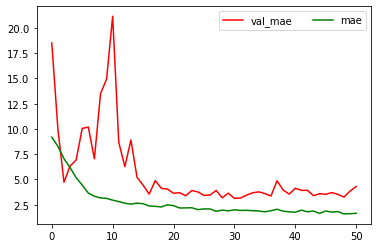

In [14]:
history.history.keys() #查看history中存储了哪些参数
plt.plot(history.epoch,history.history.get('val_mae'),'r',label='val_mae') #画出随着epoch增大loss的变化图
plt.plot(history.epoch,history.history.get('mae'),'g',label='mae')#画出随着epoch增大准确率的变化图
plt.legend(loc=0,ncol=2)

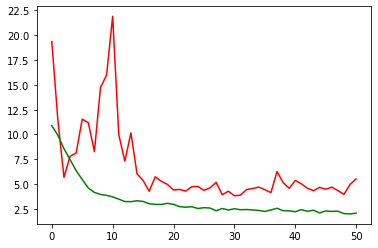

In [15]:
history.history.keys() #查看history中存储了哪些参数
plt.plot(history.epoch,history.history.get('val_loss'),'r',label='val_loss') #画出随着epoch增大loss的变化图
plt.plot(history.epoch,history.history.get('loss'),'g',label='loss')#画出随着epoch增大准确率的变化图

In [16]:
# model_name = 'audio_1.h5'
# tcn.save(model_name)

In [17]:
score_test = tcn.evaluate(x_test,y_test)
score_test

2/2 [==============================] - 0s 997us/step - loss: 5.5169 - mae: 4.3050


[5.516875267028809, 4.30502462387085]